<a href="https://colab.research.google.com/github/Abdullahaml1/learn-tensorflow/blob/main/10_audio_age_classification_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age problem using Transfer learning of yamnet model [link](https://www.tensorflow.org/tutorials/audio/transfer_learning_audio)

In [1]:
import os
import glob # for geting filenames

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile # using wavfile.read to read the wav file
from scipy import signal

import tensorflow as tf
import tensorflow_hub as hub

# Set the seed value for experiment reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print('GPU: ','available' if tf.config.list_physical_devices('GPU') else 'not avaiable') 

GPU:  available


In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
# for downloading form google drive
!gdown  https://drive.google.com/drive/folders/1aNxnIT_p5zpvsVziNLtwxOPsB1Ibf6r_ -O /tmp/Agefolder --folder

Retrieving folder list
Processing file 1rhtYVU17DEO0iKaP-9LxwKQyoxPy3nHR BVC_Age.xlsx
Processing file 1C823CPSh7_gVtceYwKoS4zasnC9XpmDD Readme.md
Processing file 1G8GAAInvMd1Ad1lpNBWTZhaLJyQwIxXx waves.zip
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1rhtYVU17DEO0iKaP-9LxwKQyoxPy3nHR
To: /tmp/Agefolder/BVC_Age.xlsx
100% 17.2k/17.2k [00:00<00:00, 32.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C823CPSh7_gVtceYwKoS4zasnC9XpmDD
To: /tmp/Agefolder/Readme.md
100% 1.66k/1.66k [00:00<00:00, 6.13MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1G8GAAInvMd1Ad1lpNBWTZhaLJyQwIxXx 

Download ended unsuccessfully


In [3]:
# mounting google dirve
from google.colab import drive
drive.mount('/content/drive')


os.chdir("drive/My Drive/Age-data-extracted/")

Mounted at /content/drive


In [ ]:
# unziping data (make this once data is zipped)
import zipfile
zipfile_name = '../Age/waves.zip'
dir_name = 'dataset'

with zipfile.ZipFile(zipfile_name, 'r') as zip_ref:
    zip_ref.extractall(dir_name)

In [ ]:
# already made do not make it agian
!cp ../Age/BVC_Age.xlsx ./

In [4]:
# reading the data
excel_file = ''
base_data_path = '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/'

pd_data = pd.read_excel('BVC_Age.xlsx')
pd_data.head()
# for index, raw in pd_data.head().iterrows():
    # print(raw['New_ID'])

,New_ID,Age
0,4001,19
1,4002,23
2,4003,18
3,4004,23
4,4005,17


In [5]:
pd_data[pd_data['New_ID']==4001]['Age'].to_numpy()[0]

19

In [6]:
# listing wav files of code:
glob.glob(f'{base_data_path}*4530*')

['/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VE1.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VE2.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VE3.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VE4.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VE5.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VV1.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VV2.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VV3.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VV4.wav',
 '/content/drive/MyDrive/Age-data-extracted/dataset/waves/multiple_sentences/S_01_4530_VV5.wav']

In [7]:
files_list = []
age_list=[]

for index, raw in pd_data.iterrows():
    code = raw['New_ID']
    files = glob.glob(f'{base_data_path}*{code}*')
    files_list = files_list + files
    age_list = age_list + [raw['Age']] * len(files)

print(len(files_list))
print(len(age_list))

3964
3964


In [8]:
# loading data set to tensorflow 
main_ds = tf.data.Dataset.from_tensor_slices((files_list, age_list))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [10]:
!pip install -U tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 40.8 MB/s eta 0:00:00


In [11]:
# loading wav files to main dataset
import tensorflow_io as tfio

@tf.function
def load_wav_16k_mono(filename, age):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
            file_contents,
            desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64) # like c type casting
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav, tf.cast(age, dtype=tf.float32)

main_ds = main_ds.map(load_wav_16k_mono)
main_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [12]:
wav, age = next(iter(main_ds.take(1)))
print(wav.shape)
print(age)
display.Audio(wav, rate=16000)

(31972,)
tf.Tensor(19.0, shape=(), dtype=float32)


In [13]:
# applying yamet embedding 
# it generate embedding every (window size) so for a single input it will produce n x 1024
# then taking the average of all the embedding for all wav files

# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, age):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    ''' averaging embeddings '''
    return (tf.math.reduce_mean(embeddings, axis=0), age)

# extract embedding
# main_ds = main_ds.map(extract_embedding).unbatch()
main_ds = main_ds.map(extract_embedding)
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [15]:
# Drops elements that cause errors.
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#ignore_errors
main_ds = main_ds.ignore_errors()

In [16]:
emed, age = next(iter(main_ds.take(1)))
print(emed.shape)
print(age)

(1024,)
tf.Tensor(19.0, shape=(), dtype=float32)


In [17]:
# spliting in train and test
BATCH_SIZE = 1024
NUM_SHARDS = 5
cached_ds = main_ds.cache()
test_ds = cached_ds.shard(num_shards=NUM_SHARDS, index=0)

train_ds = cached_ds.shard(num_shards=NUM_SHARDS, index=1)
for i in range(NUM_SHARDS-2):
    train_ds = train_ds.concatenate(cached_ds.shard(num_shards=5, index=i+2))
    
val_ds = test_ds.shard(num_shards=2, index=0) # 10% val
test_ds = test_ds.shard(num_shards=2, index=1)# 10% test


train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [18]:
embed, age = next(iter(train_ds.take(1)))
print(embed.shape)

(1024, 1024)


In [70]:
EPOCHS = 2000

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1024), dtype=tf.float32),
    tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # tf.keras.layers.Normalization(),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='relu')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=10, # weight for 3 ecpochs
                                            restore_best_weights=True)

initial_learning_rate = 0.01
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(len(age_list)/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer = tf.keras.optimizers.Adam(lr_schedule))
              # metrics=['mean_squared_error'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               131200    
                                                                 
 normalization_26 (Normaliza  (None, 128)              257       
 tion)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 131,586
Trainable params: 131,329
Non-trainable params: 257
_________________________________________________________________


In [71]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=[callback],
    verbose =2)

Epoch 1/2000
4/4 - 1s - loss: 285.9713 - val_loss: 128.5879 - 1s/epoch - 340ms/step
Epoch 2/2000
4/4 - 0s - loss: 125.5846 - val_loss: 70.2868 - 36ms/epoch - 9ms/step
Epoch 3/2000
4/4 - 0s - loss: 47.4463 - val_loss: 67.6286 - 44ms/epoch - 11ms/step
Epoch 4/2000
4/4 - 0s - loss: 65.4405 - val_loss: 50.8592 - 35ms/epoch - 9ms/step
Epoch 5/2000
4/4 - 0s - loss: 40.7926 - val_loss: 42.3665 - 35ms/epoch - 9ms/step
Epoch 6/2000
4/4 - 0s - loss: 43.4336 - val_loss: 39.8542 - 41ms/epoch - 10ms/step
Epoch 7/2000
4/4 - 0s - loss: 34.3538 - val_loss: 36.8023 - 33ms/epoch - 8ms/step
Epoch 8/2000
4/4 - 0s - loss: 35.3580 - val_loss: 37.1302 - 30ms/epoch - 7ms/step
Epoch 9/2000
4/4 - 0s - loss: 32.7137 - val_loss: 33.1424 - 32ms/epoch - 8ms/step
Epoch 10/2000
4/4 - 0s - loss: 32.2516 - val_loss: 33.9310 - 33ms/epoch - 8ms/step
Epoch 11/2000
4/4 - 0s - loss: 30.9307 - val_loss: 32.9773 - 33ms/epoch - 8ms/step
Epoch 12/2000
4/4 - 0s - loss: 30.8620 - val_loss: 33.6816 - 31ms/epoch - 8ms/step
Epoch 13

In [72]:
# test the model 
loss= model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 24.5727 - 34ms/epoch - 34ms/step


In [73]:
embed, age = next(iter(test_ds.take(1)))
print(embed[:1].shape)
print(model(embed[100:104]).numpy(), age[100:104].numpy())

(1, 1024)
[[23.169786]
 [20.870005]
 [21.719774]
 [20.137598]] [20. 30. 22. 23.]


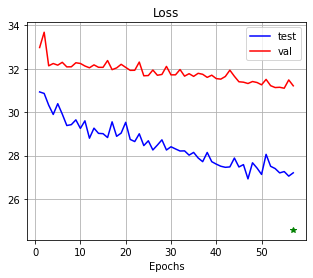

In [75]:
def plot_test_val(ax, title, test, val, test_point):
    x = np.arange(1, len(test) +1, 1)
    ax.plot(x, test, label='test', color='b')
    ax.plot(x, val, label='val', color='r')
    ax.plot([len(test)], [test_point], 'g*')
    # ax.annotate(f'test {title}={test_point:.3f}', xy=(len(test), test_point), xytext=(len(test)-1, test_point-.05))
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.set_title(title)
    ax.grid()
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_test_val(ax, 'Loss', history.history['loss'][10:], history.history['val_loss'][10:], loss)

plt.show()
